# Grating efficiency benchmark

In this example, we compute the grating efficiency of a multilevel diffraction grating whose design is inspired by the work of [Oliva et al. (2011)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-19-15-14735&id=220358).

Tidy3D uses a near field to far field transformation specialized to periodic structures to compute the grating efficiency, and its accuracy is verified through a comparison with the semi-analytical rigorous coupled wave analysis (RCWA) approach, using the open-source library [grcwa](https://grcwa.readthedocs.io/en/latest/index.html).

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from tidy3d import web


[13:24:39] WARNING  This version of Tidy3D was pip installed from the         ]8;id=698480;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=703806;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#100\100]8;;\
                    'tidy3d-beta' repository on PyPI. Future releases will be                
                    uploaded to the 'tidy3d' repository. From now on, please                 
                    use 'pip install tidy3d' instead.                                        

           INFO     Using client version: 1.9.0                               ]8;id=207501;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py\__init__.py]8;;\:]8;id=981178;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/__init__.py#115\115]8;;\

## Normal incidence

We will first analyze the grating under normal incidence, as also studied in the paper. In this case, we can use periodic boundary conditions in both tangential directions.

### Geometry setup
First, the structure and simulation geometry are defined. The structure includes a dielectric substrate with two dielectric patterned layers.

In [2]:
# Grating parameters (all lengths in um)
index = 1.46847
period = 1.866
width_layer1 = 0.519
width_layer2 = 1.202
height_layer1 = 0.333
height_layer2 = 0.281

# free space central wavelength
wavelength = 0.416

# Simulation domain geometry
space_above = wavelength * 3
height_substrate = wavelength * 3
space_below = wavelength * 3

# Define a buffer to make sure objects extend past the simulation boundary
buffer = 0.1

# Simulation domain along x and z
length_x = period
length_z = space_below + height_substrate + height_layer1 + height_layer2 + space_above

# Define the medium
grating_medium = td.Medium(permittivity=index**2)

# Create the substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z / 2 + height_substrate / 2 + space_below],
        size=[td.inf, td.inf, height_substrate],
    ),
    medium=grating_medium,
)

# Level 1 grating
center_L1 = [
    -buffer / 2 - length_x / 2 + width_layer1 / 2 + width_layer2 / 2,
    0,
    -length_z / 2 + space_below + height_substrate + height_layer2 / 2,
]
size_L1 = [width_layer1 + width_layer2 + buffer, td.inf, height_layer2]
grating_L1 = td.Structure(
    geometry=td.Box(center=center_L1, size=size_L1),
    medium=grating_medium,
)

# Level 2 grating
center_L2 = [
    -buffer / 2 - length_x / 2 + width_layer1 / 2,
    0,
    -length_z / 2 + space_below + height_substrate + height_layer2 + height_layer1 / 2,
]
size_L2 = [width_layer1 + buffer, td.inf, height_layer1]
grating_L2 = td.Structure(
    geometry=td.Box(center=center_L2, size=size_L2),
    medium=grating_medium,
)

# Collect all structures
structures = [substrate, grating_L1, grating_L2]


### Source setup
Next, define the source plane wave impinging from above the grating at normal incidence

In [3]:
# Central frequency in Hz
f0 = td.C_0 / wavelength

# Bandwidth
fwidth = f0 / 40.0

# Run time
run_time = 100 / fwidth

# Time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

# Source
src_z = length_z / 2 - space_above / 2
angle_theta = np.pi / 10
source = td.PlaneWave(
    center=(0, 0, src_z),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction="-",
    pol_angle=0,
    angle_theta=0,
    angle_phi=0,
)


### Monitor setup
Here, we'll set up a field monitor to record and plot the frequency domain fields at a plane in the `xz` cross-section. Also, we'll set up two `DiffractionMonitor`s, one for reflection, and the other for transmission.

In [4]:
# Fields
monitor_xz = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, td.inf], freqs=[f0], name="field_xz"
)

# The allowed orders will be computed automatically and returned as part of the results
monitor_r = td.DiffractionMonitor(
    center=[0.0, 0.0, length_z / 2 - wavelength],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name="reflection",
    normal_dir="+",
)

monitor_t = td.DiffractionMonitor(
    center=[0.0, 0.0, -length_z / 2 + wavelength],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name="transmission",
    normal_dir="-",
)

monitors = [monitor_xz, monitor_r, monitor_t]


### Set up boundary conditions and initialize simualtion

For normal incidence, we can use periodic boundary conditions along the `x` and `y` directions. More generally, we need to use Bloch boundary conditions as will be illustrated below. We can also use Bloch boundaries with zero Bloch vector for normal incidence, but a simulation with Bloch boundaries uses complex fields and is twice more computationally expensive than a simulation with periodic boundaries, while the results for `bloch_vec = 0` are equivalent.

Along `z`, a perfectly matched layer (PML) is applied to mimic an infinite domain. Because the diffraction grating introduces waves propagating at various angles, including steep angles with respect to the PML boundary, we use more layers than the default value to minimize spurious reflections at the PMLs.

           INFO     Auto meshing using wavelength 0.4160 defined from        ]8;id=823773;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=487787;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

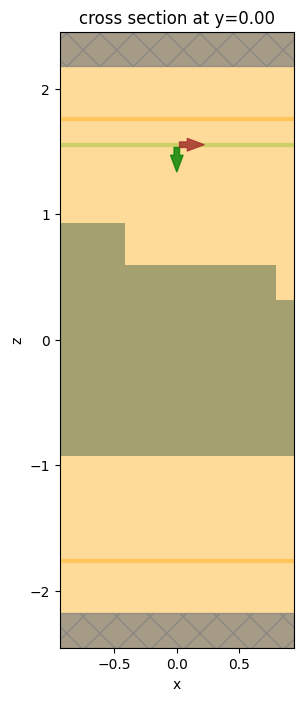

In [5]:
# Simulation size
length_y = 0  # grating is translationally invariant along y
sim_size = (length_x, length_y, length_z)

# Resolution
min_steps_per_wvl = 60

# Boundaries
num_pml_layers = 40
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary(
        minus=td.PML(num_layers=num_pml_layers), plus=td.PML(num_layers=num_pml_layers)
    ),
)

# Simulation
simulation = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
    structures=structures,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
)

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
simulation.plot(y=0, ax=ax)
plt.show()


### Run simulation

In [6]:
sim_data = web.run(
    simulation, task_name="GratingEfficiency", path="data/GratingEfficiency.hdf5"
)


[13:24:40] INFO     Using Tidy3D credentials from stored file.                     ]8;id=200827;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=573503;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#77\77]8;;\

[13:24:41] INFO     Authentication successful.                                     ]8;id=249824;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=657331;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#37\37]8;;\

           INFO     Created task 'GratingEfficiency' with task_id               ]8;id=572646;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=92276;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\
                    '74b1de98-36bf-46b2-922b-425708a4f51f'.                                  

Output()

[13:24:42] INFO     status = queued                                             ]8;id=737472;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=705041;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

Output()

[13:24:45] INFO     status = preprocess                                         ]8;id=283304;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=887237;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#275\275]8;;\

[13:24:49] INFO     Maximum FlexUnit cost: 0.061. Use 'web.real_cost(task_id)'  ]8;id=81346;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=192961;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#299\299]8;;\
                    to get the billed FlexUnit cost after a simulation run.                  

           INFO     starting up solver                                          ]8;id=767848;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=494755;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#303\303]8;;\

[13:24:59] INFO     running solver                                              ]8;id=369516;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=425684;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#313\313]8;;\

Output()

[13:25:16] INFO     early shutoff detected, exiting.                            ]8;id=861609;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=269784;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#326\326]8;;\

           INFO     status = postprocess                                        ]8;id=80247;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=445278;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#343\343]8;;\

Output()

[13:25:33] INFO     status = success                                            ]8;id=276966;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=147150;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#350\350]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=524640;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=21552;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#673\673]8;;\
                    "data/GratingEfficiency.hdf5"                                            

Output()

[13:25:35] INFO     loading SimulationData from data/GratingEfficiency.hdf5     ]8;id=976280;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=752499;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#472\472]8;;\

### Diffraction data
Now we can extract the diffracted power from the output data structures and verfify that the sum across all reflection and transmission orders is close to 1. We can also access the diffraction angles and the complex power amplitudes for each order and polarization.

In [7]:
data_r = sim_data["reflection"]
data_t = sim_data["transmission"]
print(f"Total power: {sum(sum(data_r.power.values + data_t.power.values))}")
print(f"\nTheta angles (degrees): \n{data_t.angles[0] * 180 / np.pi}")
print(f"\nAmplitude data: \n{data_t.amps}")


Total power: [0.99805612]

Theta angles (degrees): 
<xarray.DataArray (orders_x: 9, orders_y: 1, f: 1)>
array([[[63.09360835]],

       [[41.97530865]],

       [[26.47924028]],

       [[12.88158202]],

       [[ 0.        ]],

       [[12.88158202]],

       [[26.47924028]],

       [[41.97530865]],

       [[63.09360835]]])
Coordinates:
  * orders_x  (orders_x) int64 -4 -3 -2 -1 0 1 2 3 4
  * orders_y  (orders_y) int64 0
  * f         (f) float64 7.207e+14

Amplitude data: 
<xarray.DataArray (orders_x: 9, orders_y: 1, f: 1, polarization: 2)>
array([[[[ 5.11645612e-18-1.13903174e-17j,
           3.12479258e-02-6.99603999e-02j]]],


       [[[-1.25585003e-17+7.76528943e-18j,
          -9.82699229e-02+6.07843770e-02j]]],


       [[[ 3.74715505e-17-2.01430105e-17j,
           3.04128912e-01-1.63471264e-01j]]],


       [[[ 3.59066880e-17+5.03400557e-17j,
           2.93110225e-01+4.10932537e-01j]]],


       [[[ 0.00000000e+00+0.00000000e+00j,
          -9.29517749e-03+5.36648279e-01j]

### Reference results
To validate the accuracy of the results from Tidy3D, We will now compute the grating efficiency using the [grcwa](https://grcwa.readthedocs.io/en/latest/index.html) package. Be sure to install it in your Python environment first: `pip install grcwa`.

In [8]:
import grcwa

# Define lattice constants - size of the domain
# grcwa requires a finite non-zero size along each dimension
size_y = 1e-3
L1 = [sim_size[0], 0]
L2 = [0, size_y]

# Set truncation order
nG = 300

# Set up RCWA object
freq = f0 / td.C_0  # grcwa uses normalized coordinates where the speed of light is 1
obj = grcwa.obj(nG, L1, L2, freq, 0, 0, verbose=0)

# Set up the geometry (the layers are ordered top to bottom in grcwa)
num_patterned_layers = 3
thick_top = space_above
thick_layers = [height_layer1, height_layer2, height_substrate]
thick_bot = space_below

# Discretization points along x and y
num_x = 300
num_y = 100

# Permittivity info
eps_background = 1
eps_diel = index**2

# Add the layers to the grcwa model
obj.Add_LayerUniform(thick_top, eps_background)
for i in range(num_patterned_layers):
    obj.Add_LayerGrid(thick_layers[i], num_x, num_y)
obj.Add_LayerUniform(thick_bot, eps_background)

obj.Init_Setup(Gmethod=1)

if structures == []:
    eps_grid_substrate = np.ones((num_x, num_y)) * eps_background
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_background
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_background
elif len(structures) == 1:
    eps_grid_substrate = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_background
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_background
elif len(structures) == 2:
    eps_grid_substrate = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_background
else:

    eps_grid_substrate = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_diel

    # For each layer, we need to create a permittivity mask
    sim_center_rcwa = simulation.center
    sim_size_rcwa = [sim_size[0], size_y]

    # Create a grid of all possible coordinates
    x0 = np.linspace(
        sim_center_rcwa[0] - sim_size_rcwa[0] / 2,
        sim_center_rcwa[0] + sim_size_rcwa[0] / 2,
        num_x,
    )
    y0 = np.linspace(
        sim_center_rcwa[1] - sim_size_rcwa[1] / 2,
        sim_center_rcwa[1] + sim_size_rcwa[1] / 2,
        num_y,
    )
    x_sim, y_sim = np.meshgrid(x0, y0, indexing="ij")

    # Now mask out the coordinates that correspond to the dielectric regions
    center_L1 = grating_L1.geometry.center
    size_L1 = grating_L1.geometry.size

    center_L2 = grating_L2.geometry.center
    size_L2 = grating_L2.geometry.size

    def get_ind(x_grid, y_grid, diel_center, diel_size):
        """Get the anti-mask indices for a given dielectric slab."""
        ind = np.nonzero(
            (x_grid < diel_center[0] - diel_size[0] / 2)
            | (x_grid > diel_center[0] + diel_size[0] / 2)
            | (y_grid < diel_center[1] - diel_size[1] / 2)
            | (y_grid > diel_center[1] + diel_size[1] / 2)
        )
        return ind

    ind_L1 = get_ind(x_sim, x_sim, center_L1, size_L1)
    ind_L2 = get_ind(x_sim, x_sim, center_L2, size_L2)

    eps_grid_L1[ind_L1] = eps_background
    eps_grid_L2[ind_L2] = eps_background

# Combine the three layer masks
eps_grid = np.concatenate(
    (eps_grid_L2.flatten(), eps_grid_L1.flatten(), eps_grid_substrate.flatten())
)

# Apply these material masks to the model
obj.GridLayer_geteps(eps_grid)

# Set up the s-polarized plane wave source
planewave = {"p_amp": 1, "s_amp": 0, "p_phase": 0, "s_phase": 0}
obj.MakeExcitationPlanewave(
    planewave["p_amp"],
    planewave["p_phase"],
    planewave["s_amp"],
    planewave["s_phase"],
    order=0,
)

# Run grcwa to get the reflection and transmission efficiencies by order
R, T = obj.RT_Solve(normalize=1)
Ri, Ti = obj.RT_Solve(byorder=1)


def rcwa_order_index(orders_x, orders_y, obj, rcwa_data):
    """Helper function to extract data corresponding to particular order pairs."""
    ords = []
    out_data = []
    for order_y in orders_y:
        ords.append([])
        out_data.append([])
        for order_x in orders_x:
            order = [order_x, order_y]
            ords[-1].append(obj.G.tolist().index(order))
            out_data[-1].append(np.array(rcwa_data[ords[-1][-1]]))
    return ords, out_data


# Extract grcwa results at orders corresponding to those computed above by Tidy3D
r_ords, Ri_by_order = rcwa_order_index(
    data_r.orders_x,
    data_r.orders_y,
    obj,
    Ri,
)
t_ords, Ti_by_order = rcwa_order_index(
    data_t.orders_x,
    data_t.orders_y,
    obj,
    Ti,
)


### Plot and compare diffracted power
Since this is essentially a 1D grating along `x`, we'll plot the power, which is normalized and corresponds to the grating efficiency, as a function of `x` for order 0 in `y`. The results are in excellent agreement with each other.

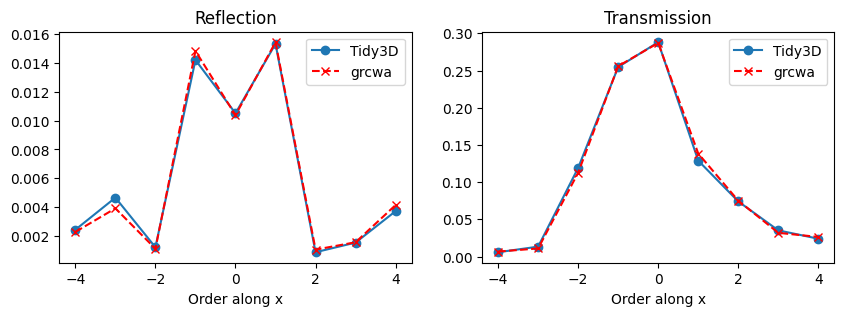

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

orders_x = data_r.orders_x
ax[0].plot(orders_x, data_r.power.values[:, 0], "o-", label="Tidy3D")
ax[0].plot(orders_x, Ri_by_order[0], "x--r", label="grcwa")
ax[0].set_title("Reflection")
ax[0].set_xlabel("Order along x")
ax[0].legend()

orders_x = data_t.orders_x
ax[1].plot(orders_x, data_t.power.values[:, 0], "o-", label="Tidy3D")
ax[1].plot(orders_x, Ti_by_order[0], "x--r", label="grcwa")
ax[1].set_title("Transmission")
ax[1].set_xlabel("Order along x")
ax[1].legend()

plt.show()


### Plot and compare power amplitudes
We can also compare the transmitted complex power amplitude for each order and each polarization to those obtained via the [grcwa](https://grcwa.readthedocs.io/en/latest/index.html) package. The power amplitudes are complex and provide information about the phase difference among different orders.

Note that grcwa returns fields in Cartesian coordinates, while Tidy3D returns power amplitudes in the `s` and `p` polarization basis. Therefore, we will use some convenience methods to convert grcwa's fields to spherical coordinates before comparing the two solvers.

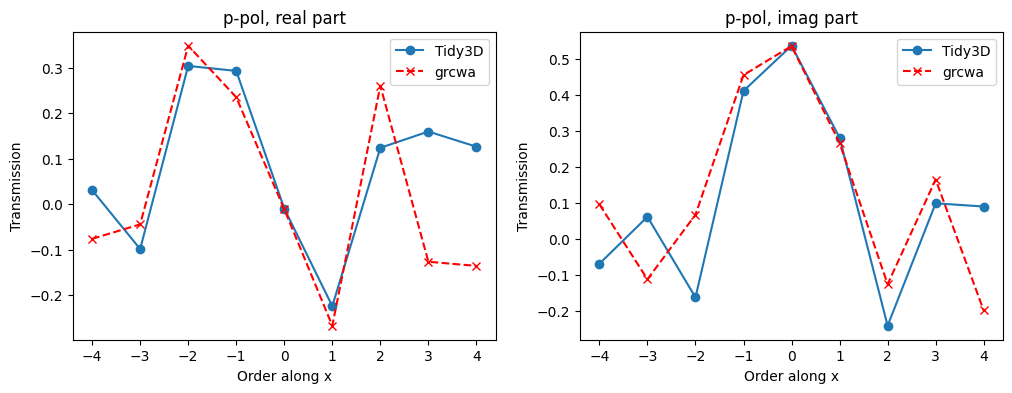

In [10]:
import xarray as xr

# get amplitudes from Tidy3D results
amps_sp = data_t.amps

# get amplitudes from grcwa

# we're sampling near-fields in the lower-most layer
layer = 4
# position above the simulation domain's bottom where we're sampling
z_offset = monitor_t.center[2] - (-sim_size[2] / 2)
amps_grcwa_xy, _ = obj.Solve_FieldFourier(layer, z_offset)

# Extract grcwa results at orders corresponding to those computed by Tidy3D
amps_grcwa_xy = [
    np.array(rcwa_order_index(data_t.orders_x, data_t.orders_y, obj, amps)[1])
    for amps in amps_grcwa_xy
]

# we need to swap the axes as below for the data to match Tidy3D data
amps_grcwa_xy = [np.swapaxes(amps, 0, 1) for amps in amps_grcwa_xy]

# # to match the format of Tidy3D data, add a frequency dimension
amps_grcwa_xy = [amps[..., None] for amps in amps_grcwa_xy]

# convert to spherical coordinates
theta, phi = data_t.angles
amps_grcwa_tp = data_t.monitor.car_2_sph_field(
    amps_grcwa_xy[0], amps_grcwa_xy[1], amps_grcwa_xy[2], theta.values, phi.values
)

# make an xarray dataset for the rcwa amplitudes
coords = {}
coords["orders_x"] = np.atleast_1d(data_t.orders_x)
coords["orders_y"] = np.atleast_1d(data_t.orders_y)
coords["f"] = np.array(data_t.f)
coords["polarization"] = ["s", "p"]
amps_grcwa_sp = xr.DataArray(
    np.stack([amps_grcwa_tp[2], amps_grcwa_tp[1]], axis=3), coords=coords
)

# finally, we can compare the complex amplitudes for the y=0 order, as a function of orders along x
pol = "p"
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
orders_x = data_t.orders_x
data_tidy3d = data_t.amps.sel(polarization=pol).values[:, 0]
data_grcwa = amps_grcwa_sp.sel(polarization=pol).values[:, 0]

ax[0].plot(orders_x, np.real(data_tidy3d), "o-", label="Tidy3D")
ax[0].plot(orders_x, np.real(data_grcwa), "x--r", label="grcwa")
ax[0].set_title(f"{pol}-pol, real part")
ax[0].set_ylabel("Transmission")
ax[0].set_xlabel("Order along x")
ax[0].legend()

ax[1].plot(orders_x, np.imag(data_tidy3d), "o-", label="Tidy3D")
ax[1].plot(orders_x, np.imag(data_grcwa), "x--r", label="grcwa")
ax[1].set_title(f"{pol}-pol, imag part")
ax[1].set_ylabel("Transmission")
ax[1].set_xlabel("Order along x")
ax[1].legend()

plt.show()


### Plot Field Distributions
Plot the frequency-domain electric field components at the center frequency along an `xz` cut of the domain. The `y` component is zero everywhere because the wave is entirely `x`-polarized.

[13:25:43] INFO     Auto meshing using wavelength 0.4160 defined from        ]8;id=679884;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=904175;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

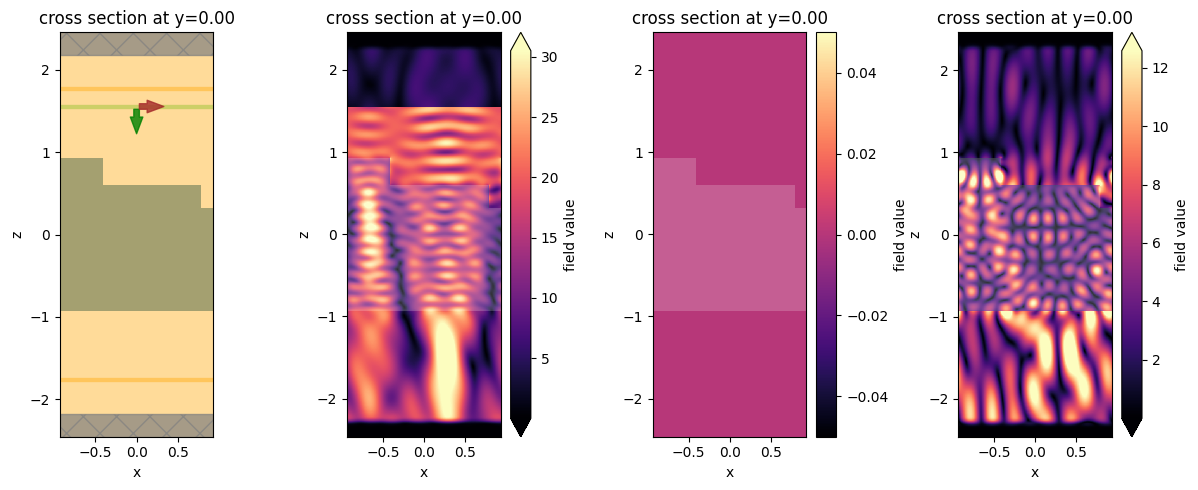

In [11]:
data = sim_data["field_xz"]
fig, axs = plt.subplots(1, 4, tight_layout=True, figsize=(12, 5))
sim_data.simulation.plot(y=0, ax=axs[0])
sim_data.plot_field(
    field_name="Ex", field_monitor_name="field_xz", ax=axs[1], val="abs"
)
sim_data.plot_field(
    field_name="Ey", field_monitor_name="field_xz", ax=axs[2], val="abs"
)
sim_data.plot_field(
    field_name="Ez", field_monitor_name="field_xz", ax=axs[3], val="abs"
)
plt.show()


## Off-normal incidence

To study a diffraction grating under an angled illumination, we need to use Bloch boundary conditions along the `x` and `y` directions that match the incoming wave. The Bloch vector can be automatically computed based on the plane wave parameters, as shown below.

If the illumination is such that the angle is non-zero along y, a slightly special treatment is required in that we cannot set the simulation size to zero in that direction anymore. Instead we should define the simulation length to be a small finite value, and set the mesh step in that direction to the same value.

[13:25:46] INFO     Auto meshing using wavelength 0.4160 defined from        ]8;id=50641;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=989210;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

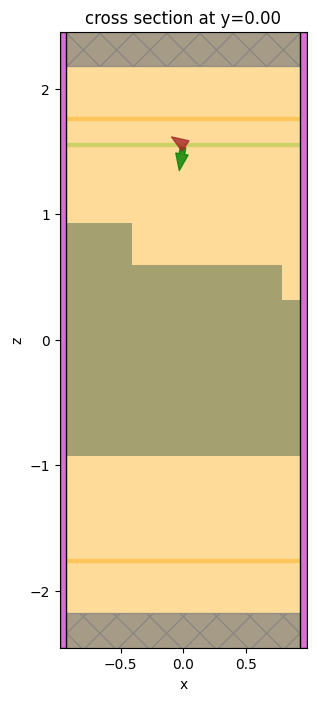

In [12]:
# Angles
angle_theta = np.pi / 10
angle_phi = np.pi / 3

# Simulation size
length_y = 0.01  # needed when angle_phi is not zero
sim_size = (length_x, length_y, length_z)

# Angled source
src_z = length_z / 2 - space_above / 2
angle_theta = np.pi / 10
source = td.PlaneWave(
    center=(0, 0, src_z),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    direction="-",
    pol_angle=0,
    angle_theta=angle_theta,
    angle_phi=angle_phi,
)

# Boundaries
bloch_x = td.Boundary.bloch_from_source(source=source, domain_size=sim_size[0], axis=0)
bloch_y = td.Boundary.bloch_from_source(source=source, domain_size=sim_size[1], axis=1)
boundary_spec = td.BoundarySpec(
    x=bloch_x,
    y=bloch_y,
    z=td.Boundary(
        minus=td.PML(num_layers=num_pml_layers), plus=td.PML(num_layers=num_pml_layers)
    ),
)

# Simulation
simulation = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec(
        grid_x=td.AutoGrid(min_steps_per_wvl=60),
        grid_y=td.UniformGrid(dl=sim_size[1]),
        grid_z=td.AutoGrid(min_steps_per_wvl=60),
    ),
    structures=structures,
    sources=[source],
    monitors=monitors,
    run_time=run_time * 2,
    boundary_spec=boundary_spec,
)

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
simulation.plot(y=0, ax=ax)
plt.show()


In [13]:
sim_data = web.run(
    simulation, task_name="GratingEfficiency", path="data/GratingEfficiency.hdf5"
)


[13:25:50] INFO     Created task 'GratingEfficiency' with task_id               ]8;id=207414;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=130416;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#131\131]8;;\
                    '04ad8c3d-8f99-457c-b634-d244e6d824a1'.                                  

Output()

[13:25:51] INFO     status = queued                                             ]8;id=171533;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=607161;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

Output()

[13:25:53] INFO     status = preprocess                                         ]8;id=560371;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=155281;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#275\275]8;;\

[13:25:58] INFO     Maximum FlexUnit cost: 0.649. Use 'web.real_cost(task_id)'  ]8;id=746621;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=981251;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#299\299]8;;\
                    to get the billed FlexUnit cost after a simulation run.                  

           INFO     starting up solver                                          ]8;id=756078;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=120263;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#303\303]8;;\

[13:26:08] INFO     running solver                                              ]8;id=988990;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=834717;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#313\313]8;;\

Output()

[13:32:30] INFO     early shutoff detected, exiting.                            ]8;id=79766;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=951486;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#326\326]8;;\

           INFO     status = postprocess                                        ]8;id=531793;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=19436;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#343\343]8;;\

Output()

[13:32:50] INFO     status = success                                            ]8;id=633816;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=438766;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#350\350]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=3362;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=348004;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#673\673]8;;\
                    "data/GratingEfficiency.hdf5"                                            

Output()

[13:32:52] INFO     loading SimulationData from data/GratingEfficiency.hdf5     ]8;id=600587;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=471639;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#472\472]8;;\

In [14]:
data_r = sim_data["reflection"]
data_t = sim_data["transmission"]
print(f"Total power: {sum(sum(data_r.power.values + data_t.power.values))}")
print(f"\nTheta angles (degrees): \n{data_t.angles[0] * 180 / np.pi}")
print(f"\nAmplitude data: \n{data_t.amps}")


Total power: [1.00027099]

Theta angles (degrees): 
<xarray.DataArray (orders_x: 9, orders_y: 1, f: 1)>
array([[[59.96510993]],

       [[41.09624023]],

       [[27.56093082]],

       [[18.        ]],

       [[16.03511623]],

       [[23.30441275]],

       [[35.4338644 ]],

       [[51.65673818]],

       [[85.39539255]]])
Coordinates:
  * orders_x  (orders_x) int64 -3 -2 -1 0 1 2 3 4 5
  * orders_y  (orders_y) int64 0
  * f         (f) float64 7.207e+14

Amplitude data: 
<xarray.DataArray (orders_x: 9, orders_y: 1, f: 1, polarization: 2)>
array([[[[-0.056646  +0.05397192j, -0.08835352+0.0328627j ]]],


       [[[ 0.03238696+0.14692346j,  0.07478751+0.24756415j]]],


       [[[-0.08489251-0.16559582j, -0.25389773-0.37728034j]]],


       [[[ 0.01336716-0.00702348j, -0.44102545+0.21494822j]]],


       [[[ 0.08295826+0.25085525j, -0.08892289-0.31271915j]]],


       [[[ 0.14513275-0.20704371j, -0.05325256+0.06907594j]]],


       [[[-0.01250291+0.0823509j , -0.02001388+0.01585263j]]

We still used a P-polarized source (`pol_angle = 0` in the source defition), but now we also get nonzero `polarization = "s"` amplitudes in the data. This is because the input polarization is at an angle with respect to the `x`-axis, and is not preserved by the translational invariance along `y`. Similarly, now there is a nonzero `Ey` field component in the recorded near fields.

           INFO     Auto meshing using wavelength 0.4160 defined from        ]8;id=455986;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=353277;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

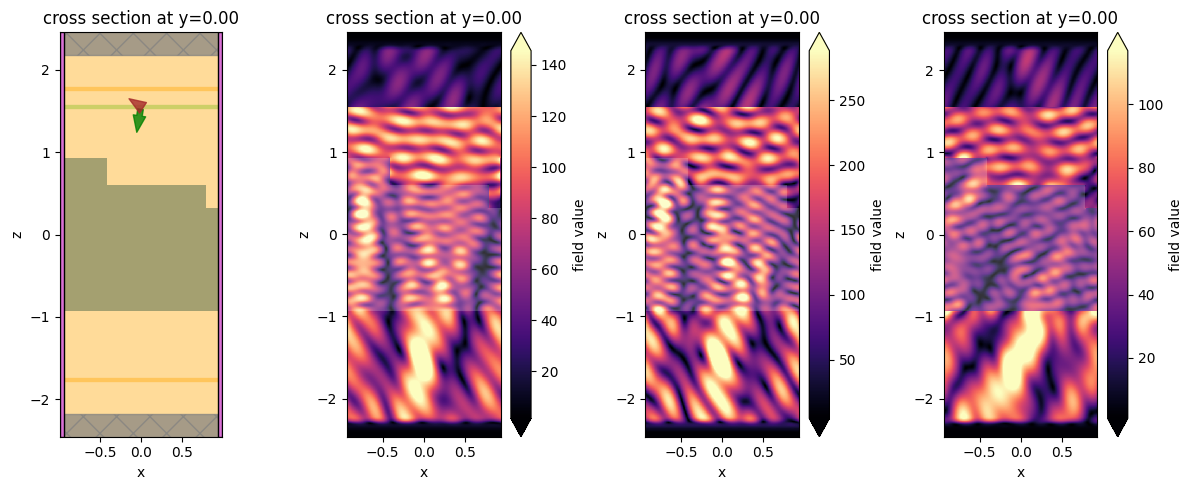

In [15]:
data = sim_data["field_xz"]
fig, axs = plt.subplots(1, 4, tight_layout=True, figsize=(12, 5))
sim_data.simulation.plot(y=0, ax=axs[0])
sim_data.plot_field(
    field_name="Ex", field_monitor_name="field_xz", ax=axs[1], val="abs"
)
sim_data.plot_field(
    field_name="Ey", field_monitor_name="field_xz", ax=axs[2], val="abs"
)
sim_data.plot_field(
    field_name="Ez", field_monitor_name="field_xz", ax=axs[3], val="abs"
)
plt.show()


### Comparison to RCWA

We can also compare to RCWA results as before. Note that, because we are injecting backwards, we need to add an `np.pi` to `angle_theta` in the `grcwa` computation.

In [16]:
# Define lattice constants - size of the domain
# grcwa requires a finite non-zero size along each dimension
size_y = 1e-3
L1 = [sim_size[0], 0]
L2 = [0, size_y]

# Set truncation order
nG = 300

# Set up RCWA object
freq = f0 / td.C_0  # grcwa uses normalized coordinates where the speed of light is 1
obj = grcwa.obj(nG, L1, L2, freq, angle_theta + np.pi, angle_phi, verbose=0)

# Set up the geometry (the layers are ordered top to bottom in grcwa)
num_patterned_layers = 3
thick_top = space_above
thick_layers = [height_layer1, height_layer2, height_substrate]
thick_bot = space_below

# Discretization points along x and y
num_x = 300
num_y = 100

# Permittivity info
eps_background = 1
eps_diel = index**2

# Add the layers to the grcwa model
obj.Add_LayerUniform(thick_top, eps_background)
for i in range(num_patterned_layers):
    obj.Add_LayerGrid(thick_layers[i], num_x, num_y)
obj.Add_LayerUniform(thick_bot, eps_background)

obj.Init_Setup(Gmethod=1)

if structures == []:
    eps_grid_substrate = np.ones((num_x, num_y)) * eps_background
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_background
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_background
elif len(structures) == 1:
    eps_grid_substrate = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_background
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_background
elif len(structures) == 2:
    eps_grid_substrate = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_background
else:

    eps_grid_substrate = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L1 = np.ones((num_x, num_y)) * eps_diel
    eps_grid_L2 = np.ones((num_x, num_y)) * eps_diel

    # For each layer, we need to create a permittivity mask
    sim_center_rcwa = simulation.center
    sim_size_rcwa = [sim_size[0], size_y]

    # Create a grid of all possible coordinates
    x0 = np.linspace(
        sim_center_rcwa[0] - sim_size_rcwa[0] / 2,
        sim_center_rcwa[0] + sim_size_rcwa[0] / 2,
        num_x,
    )
    y0 = np.linspace(
        sim_center_rcwa[1] - sim_size_rcwa[1] / 2,
        sim_center_rcwa[1] + sim_size_rcwa[1] / 2,
        num_y,
    )
    x_sim, y_sim = np.meshgrid(x0, y0, indexing="ij")

    # Now mask out the coordinates that correspond to the dielectric regions
    center_L1 = grating_L1.geometry.center
    size_L1 = grating_L1.geometry.size

    center_L2 = grating_L2.geometry.center
    size_L2 = grating_L2.geometry.size

    def get_ind(x_grid, y_grid, diel_center, diel_size):
        """Get the anti-mask indices for a given dielectric slab."""
        ind = np.nonzero(
            (x_grid < diel_center[0] - diel_size[0] / 2)
            | (x_grid > diel_center[0] + diel_size[0] / 2)
            | (y_grid < diel_center[1] - diel_size[1] / 2)
            | (y_grid > diel_center[1] + diel_size[1] / 2)
        )
        return ind

    ind_L1 = get_ind(x_sim, x_sim, center_L1, size_L1)
    ind_L2 = get_ind(x_sim, x_sim, center_L2, size_L2)

    eps_grid_L1[ind_L1] = eps_background
    eps_grid_L2[ind_L2] = eps_background

# Combine the three layer masks
eps_grid = np.concatenate(
    (eps_grid_L2.flatten(), eps_grid_L1.flatten(), eps_grid_substrate.flatten())
)

# Apply these material masks to the model
obj.GridLayer_geteps(eps_grid)

# Set up the s-polarized plane wave source
planewave = {"p_amp": 1, "s_amp": 0, "p_phase": 0, "s_phase": 0}
obj.MakeExcitationPlanewave(
    planewave["p_amp"],
    planewave["p_phase"],
    planewave["s_amp"],
    planewave["s_phase"],
    order=0,
)

# Run grcwa to get the reflection and transmission efficiencies by order
R, T = obj.RT_Solve(normalize=1)
Ri, Ti = obj.RT_Solve(byorder=1)


def rcwa_order_index(orders_x, orders_y, obj, rcwa_data):
    """Helper function to extract data corresponding to particular order pairs."""
    ords = []
    out_data = []
    for order_y in orders_y:
        ords.append([])
        out_data.append([])
        for order_x in orders_x:
            order = [order_x, order_y]
            ords[-1].append(obj.G.tolist().index(order))
            out_data[-1].append(np.array(rcwa_data[ords[-1][-1]]))
    return ords, out_data


# Extract grcwa results at orders corresponding to those computed above by Tidy3D
r_ords, Ri_by_order = rcwa_order_index(
    data_r.orders_x,
    data_r.orders_y,
    obj,
    Ri,
)
t_ords, Ti_by_order = rcwa_order_index(
    data_t.orders_x,
    data_t.orders_y,
    obj,
    Ti,
)


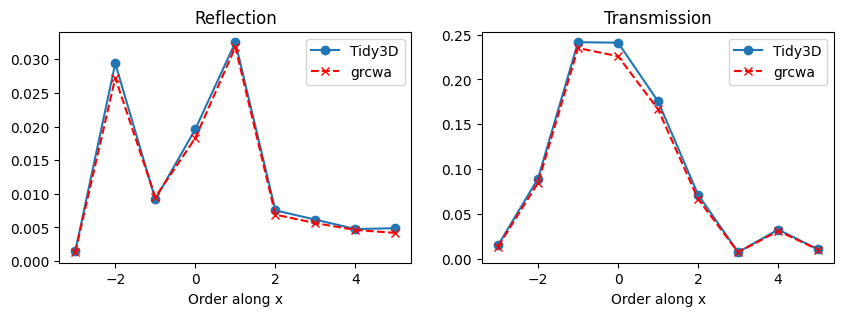

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

orders_x = data_r.orders_x
ax[0].plot(orders_x, data_r.power.values[:, 0], "o-", label="Tidy3D")
ax[0].plot(orders_x, Ri_by_order[0], "x--r", label="grcwa")
ax[0].set_title("Reflection")
ax[0].set_xlabel("Order along x")
ax[0].legend()

orders_x = data_t.orders_x
ax[1].plot(orders_x, data_t.power.values[:, 0], "o-", label="Tidy3D")
ax[1].plot(orders_x, Ti_by_order[0], "x--r", label="grcwa")
ax[1].set_title("Transmission")
ax[1].set_xlabel("Order along x")
ax[1].legend()

plt.show()
